# Imports

In [1]:
import numpy as np
import IPython
import h5py
from scipy import signal
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Cargamos las señales

In [2]:
H1 = h5py.File('../data/H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5',  'r')
L1 = h5py.File('../data/L-L1_GWOSC_4KHZ_R1-1126259447-32.hdf5',  'r')

In [3]:
print(list(H1.keys()))
print(list(L1.keys()))

['meta', 'quality', 'strain']
['meta', 'quality', 'strain']


In [4]:
for element in H1['meta']:
  print(element)
for element in H1['quality']:
  print(element)
for element in H1['strain']:
  print(element)

Description
DescriptionURL
Detector
Duration
GPSstart
Observatory
Type
UTCstart
detail
injections
simple
Strain


In [5]:
metaH1 = H1[u'meta']
qualityH1 = H1[u'quality']
strainH1 = H1[u'strain']
metaL1 = L1[u'meta']
qualityL1 = L1[u'quality']
strainL1 = L1[u'strain']

In [6]:
dataH1 = np.array(strainH1['Strain'])
dataL1 = np.array(strainL1['Strain'])

In [7]:
print('strain_H1: len, min, mean, max = ', len(dataH1), dataH1.min(),dataH1.mean(),dataH1.max())
print('strain_L1: len, min, mean, max = ', len(dataL1), dataL1.min(),dataL1.mean(),dataL1.max())

strain_H1: len, min, mean, max =  131072 -7.04466594316914e-19 -3.7594485871462737e-23 7.706262192395323e-19
strain_L1: len, min, mean, max =  131072 -1.8697138664246853e-18 -1.0522364772927026e-18 -4.600351113064713e-20


In [8]:
print(dataH1)
print(dataL1)

[9.06730891e-21 2.01178871e-20 3.71290472e-20 ... 5.32101440e-20
 4.74831535e-20 7.76456828e-20]
[-1.00432555e-18 -9.58114996e-19 -9.03059379e-19 ... -1.10862808e-18
 -1.13349772e-18 -1.12487097e-18]


# Ploteamos las señales

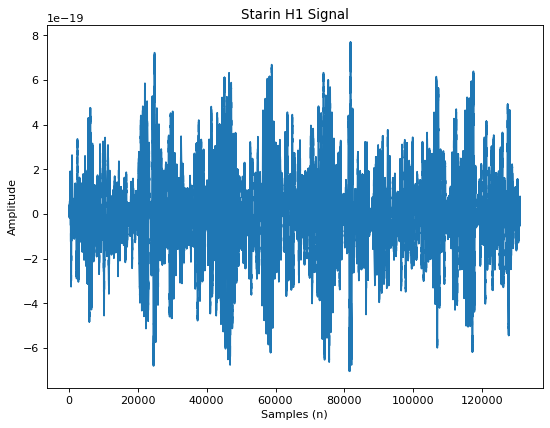

In [9]:
plt.figure(num=None, figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(dataH1)
plt.ylabel('Amplitude')
plt.xlabel('Samples (n)')
plt.title('Starin H1 Signal')
plt.show()

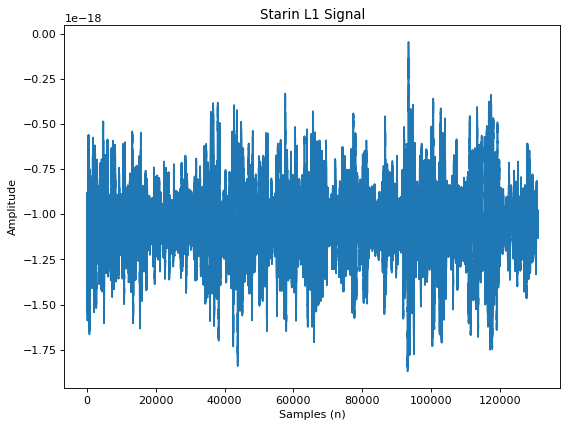

In [10]:
plt.figure(num=None, figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(dataL1)
plt.ylabel('Amplitude')
plt.xlabel('Samples (n)')
plt.title('Starin L1 Signal')
plt.show()

# Estimacion del espectro de potencia del ruido de H1 y L1

## Periodograma

In [11]:
dt = 1/4096

In [12]:
N_event = 62000
fftL1 = np.fft.rfft(dataL1[0:N_event])
fftH1 = np.fft.rfft(dataH1[0:N_event])

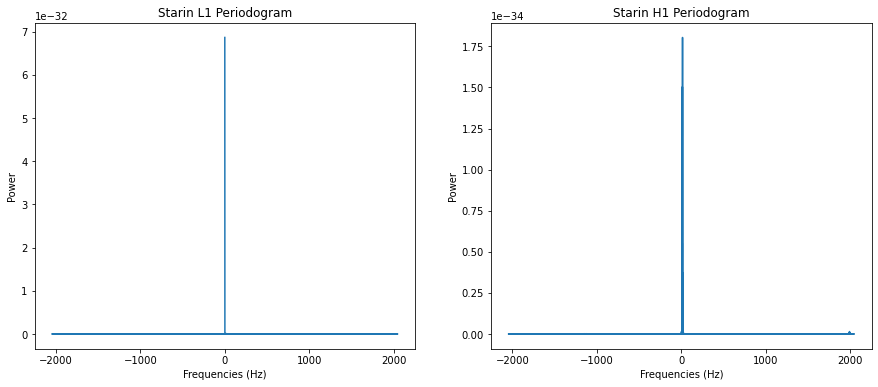

In [13]:
freqL1 = np.fft.fftfreq(len(fftL1),d=1/4096)
freqH1 = np.fft.fftfreq(len(fftH1),d=1/4096)
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(freqL1, abs(fftL1)**2/N_event)
plt.ylabel('Power')
plt.xlabel('Frequencies (Hz)')
plt.title('Starin L1 Periodogram')
plt.subplot(122)
plt.plot(freqH1, abs(fftH1)**2/N_event)
plt.ylabel('Power')
plt.xlabel('Frequencies (Hz)')
plt.title('Starin H1 Periodogram')
plt.show()

In [14]:
def plotStrainASD(freqs1, freqs2, Pxx1, Pxx2, fmin, fmax, filename='ASD.png', show=True, yMin=1e-24, yMax=1e-19,title=''):
    plt.figure(num=None, figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')
    plt.loglog(freqs1, np.sqrt(Pxx1),'r',label='H1 strain')
    plt.loglog(freqs2, np.sqrt(Pxx2),'g',label='L1 strain')
    plt.axis([fmin, fmax, yMin, yMax])
    plt.grid('on')
    plt.ylabel('ASD (strain/rtHz)')
    plt.xlabel('Freq (Hz)')
    plt.legend(loc='upper center')
    plt.title('Amplitude Spectral Density ' + title)
    plt.savefig(filename)
    if show:
        plt.plot()

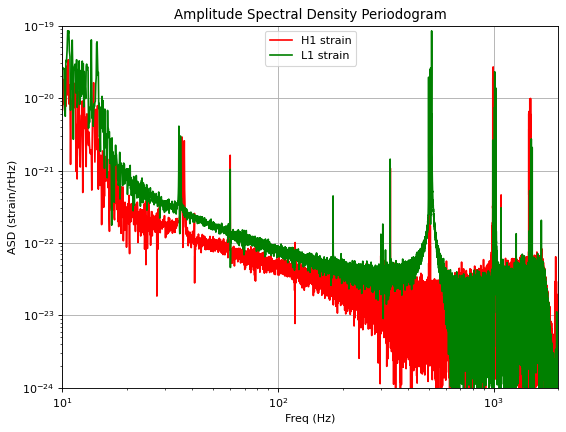

In [15]:
fs = 4096
norm = 2/fs
freqs1 = np.fft.fftfreq(len(dataL1[0:N_event]),d=1/4096)
freqs2 = np.fft.fftfreq(len(dataH1[0:N_event]),d=1/4096)
freqs1 = freqs1[:len(freqs1)//2]
freqs2 = freqs2[:len(freqs2)//2]
PxxH1_FFT = norm*abs(fftH1)**2/N_event
PxxL1_FFT = norm*abs(fftL1)**2/N_event
fmin = 10
fmax = 2000
plotStrainASD(freqs1,freqs2, PxxH1_FFT[:-1], PxxL1_FFT[:-1], fmin, fmax, filename='ASD-Periodogram.png',title='Periodogram')

## Metodo Welch Bartlett

In [16]:
# Segmentamos los datos
def segmentation(data,D,L,K):
  return [data[x:x+L] for x in range(0,K*(L-D),L-D)]

In [17]:
# Aplicamos ventana a los segmentos
def windowSegments(segments,window):
  windowed = list()
  window = np.array(window)
  segments = np.array(segments)
  for segment in segments:
    # Apply Window to segment
    windowed.append(segment*window)
  return windowed

In [18]:
# Aplicamos DFT a los segmentos
def dftSegments(segments,padding=None):
  if padding == None:
    zero_padding = 0
  else:
    zero_padding = padding
  dfts = list()
  for segment in segments:
    dft = np.fft.fft(segment,n=len(segment)+zero_padding)
    dfts.append(dft)
  return dfts

In [19]:
# Aplicamos modulo al cuadrado a las DFT
def spectrumSegments(dfts):
  spectrums = list()
  for segment in dfts:
    auxSpec = abs(segment)**2
    spectrums.append(auxSpec[:int(len(segment)/2)+1])
  return spectrums

In [20]:
# Acumulamos y normalizamos los segmentos
def cumSumSpectrums(spectrums,L,fs):
    if len(spectrums) == 1:
        return spectrums[0]*(2/fs)
    else:
        spectrum = np.zeros(len(spectrums[0]))
        norm = 2/(len(spectrums)*L*fs)
        for i in range(len(spectrums[0])):
            auxValue = 0
            for segment in spectrums:
                auxValue  = auxValue + segment[i]
            spectrum[i] = norm*auxValue
        return spectrum

In [21]:
# D: Overlap
# L: Longitud de segmentos
# K: Numero de segmentos
def welchBartlett(data,fs,D,L,k,window,padding=None):
  segmentsWB = segmentation(data,D,L,k)
  windowedWB = windowSegments(segmentsWB, window)
  dftsWB = dftSegments(windowedWB,padding)
  spectrumsWB = spectrumSegments(dftsWB)
  spectrumWB = cumSumSpectrums(spectrumsWB,L,fs)
  return spectrumWB

### Parametros Welch Bartlett
Para el calculo de los parametros, elegimos no tener overlap para que los segmentos sean independientes entre si (lo mas posible) de manera que no haya correlacion entre los segmentos. Para el calculo de la longitud del segmento, se itero por un tamaño de nperseg de $ 2^{i} $ con i entre $ 8 $ y $ 15 $. Se puede ver claramente como al aumentar nperseg, disminuye K (numero de segmentos totales). Esto causa que aumente la varianza, ya que Welch Bartlett tiene un factor de reduccion de $ 1/K $. Por lo que al aumentar nperseg aumenta la varianza pero tambien aumenta la resolucion en frecuencia. De esta manera se debe tener en cuenta una relacion de compromisos. Viendo graficamente los diferentes casos, se decidio utilizar $ nperseg = 2^{12} $ , donde se ve una buena relacion de compormisos entre la varianza y la resolucion. El proximo paso fue elegir la ventana mas adecuada. Para ello se grafico el resultado de aplicar diferentes ventanas con el nperseg obtenido anteriormente. Se puede ver como la ventana de hann y la de blackman producen los mejores resultados.

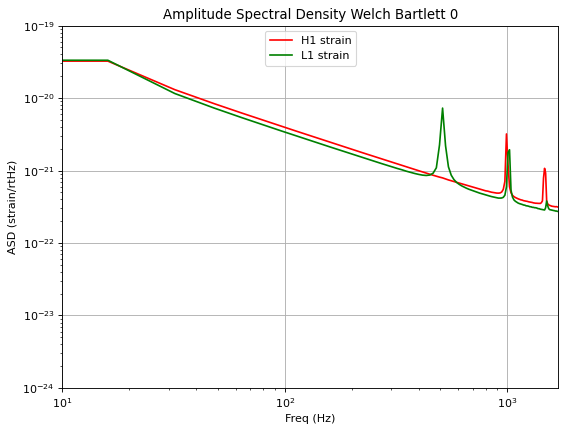

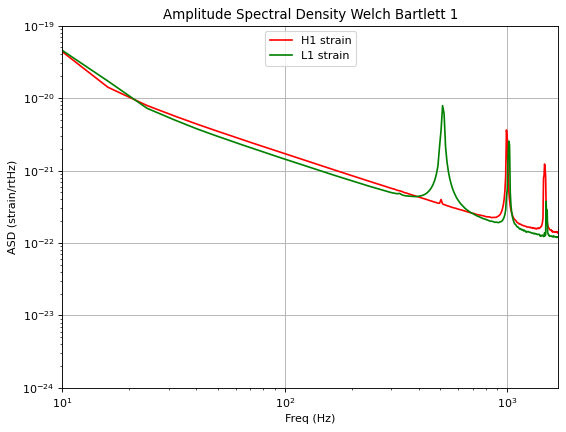

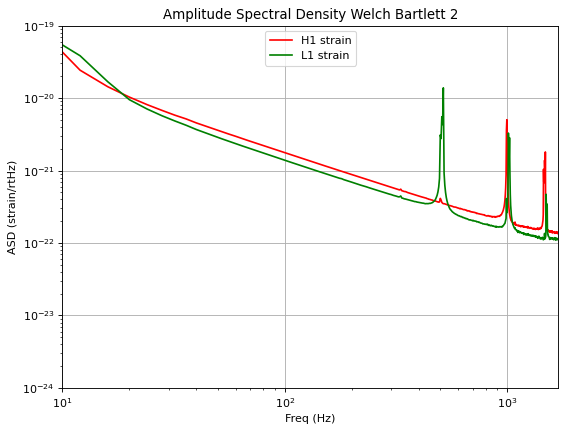

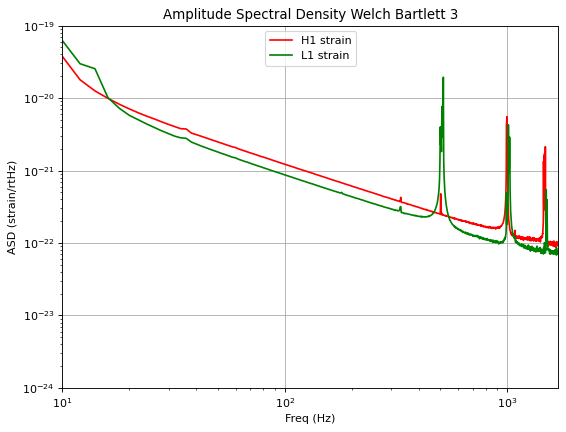

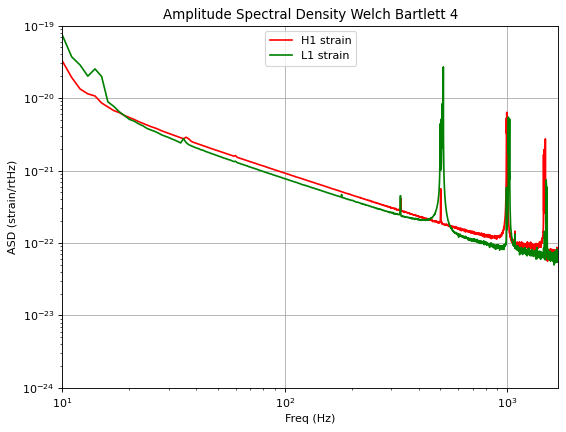

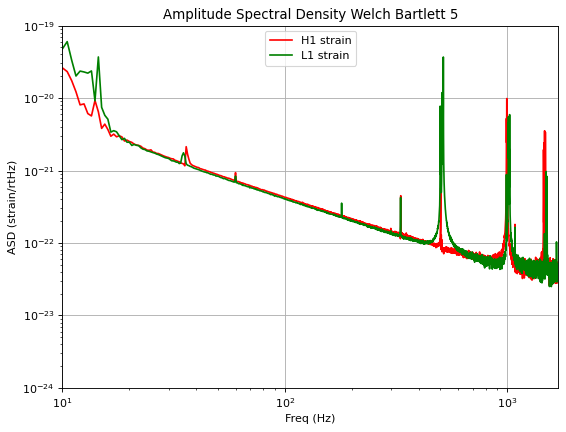

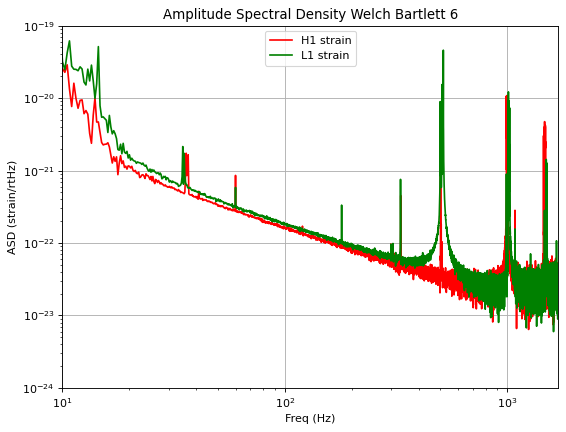

In [22]:
for i in range(7):
    nperseg = 2**(8+i)
    fmin = 10
    fmax = 1700
    freqs1 = np.fft.fftfreq(nperseg,d=1/4096)
    freqs2 = np.fft.fftfreq(nperseg,d=1/4096)
    freqs1 = freqs1[:len(freqs1)//2]
    freqs2 = freqs2[:len(freqs2)//2]
    PxxH1_WB =  welchBartlett(dataH1[0:N_event], fs=4096, D=0, L=nperseg, k=int(N_event/nperseg), window = signal.get_window('boxcar', nperseg))
    PxxL1_WB =  welchBartlett(dataL1[0:N_event], fs=4096, D=0, L=nperseg, k=int(N_event/nperseg), window = signal.get_window('boxcar', nperseg))
    plotStrainASD(freqs1, freqs2, PxxH1_WB[:-1], PxxL1_WB[:-1], fmin, fmax, filename='ASD-Welch-Bartlett-Method.png',title='Welch Bartlett '+str(i))

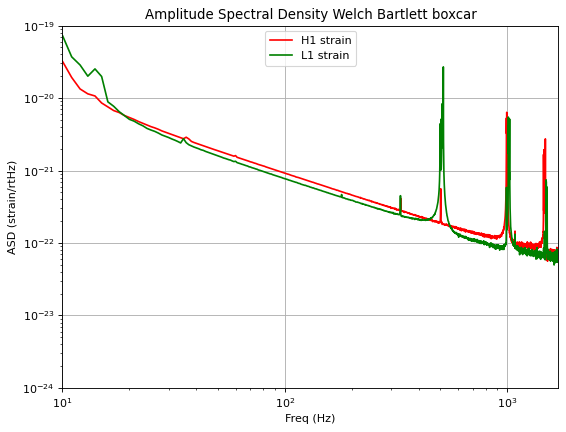

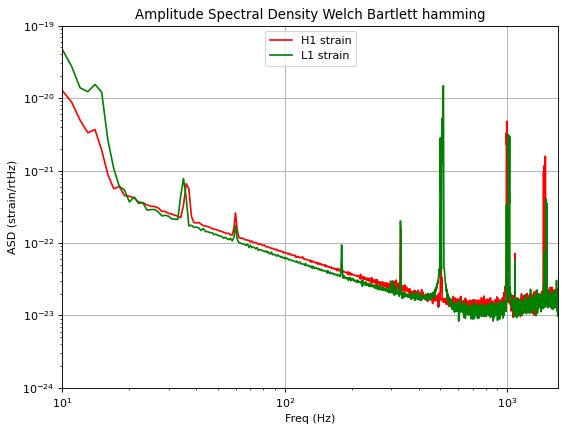

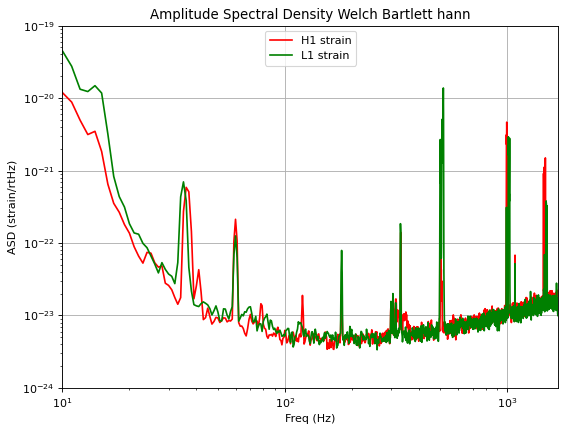

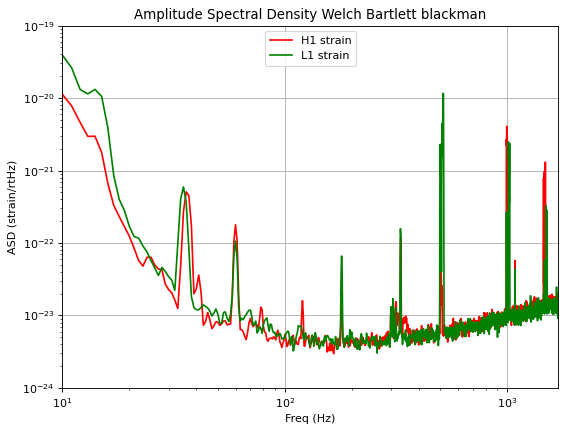

In [23]:
nperseg = 2**12
fmin = 10
fmax = 1700
windows = ['boxcar','hamming','hann','blackman']
freqs1 = np.fft.fftfreq(nperseg,d=1/4096)
freqs2 = np.fft.fftfreq(nperseg,d=1/4096)
freqs1 = freqs1[:len(freqs1)//2]
freqs2 = freqs2[:len(freqs2)//2]
for window in windows:
    PxxH1_WB =  welchBartlett(dataH1[0:N_event], fs=4096, D=0, L=nperseg, k=int(N_event/nperseg), window = signal.get_window(window, nperseg))
    PxxL1_WB =  welchBartlett(dataL1[0:N_event], fs=4096, D=0, L=nperseg, k=int(N_event/nperseg), window = signal.get_window(window, nperseg))
    plotStrainASD(freqs1, freqs2, PxxH1_WB[:-1], PxxL1_WB[:-1], fmin, fmax, filename='ASD-Welch-Bartlett-Method.png',title='Welch Bartlett '+ window)

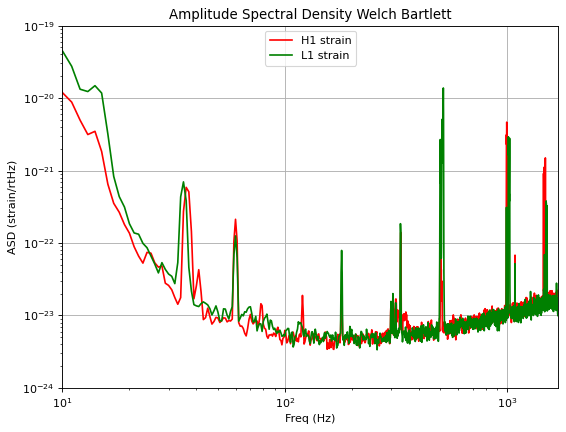

In [24]:
nperseg = 2**12
fmin = 10
fmax = 1700
freqs1 = np.fft.fftfreq(nperseg,d=1/4096)
freqs2 = np.fft.fftfreq(nperseg,d=1/4096)
freqs1 = freqs1[:len(freqs1)//2]
freqs2 = freqs2[:len(freqs2)//2]
PxxH1_WB =  welchBartlett(dataH1[0:N_event], fs=4096, D=0, L=nperseg, k=int(N_event/nperseg), window = signal.get_window('hann', nperseg))
PxxL1_WB =  welchBartlett(dataL1[0:N_event], fs=4096, D=0, L=nperseg, k=int(N_event/nperseg), window = signal.get_window('hann', nperseg))
plotStrainASD(freqs1, freqs2, PxxH1_WB[:-1], PxxL1_WB[:-1], fmin, fmax, filename='ASD-Welch-Bartlett-Method.png',title='Welch Bartlett')

## Estimación multitaper

In [25]:
def multitaperDPSS(data,n,fs):
    windows = signal.windows.dpss(M=len(data), NW=10, Kmax=n, sym=False, norm='approximate')
    spectrums = list()
    for i in range(n):
        spectrums.append(welchBartlett(data, fs=fs, D=0, L=len(data), k=1, window = windows[i]))
    return cumSumSpectrums(spectrums,n,fs)

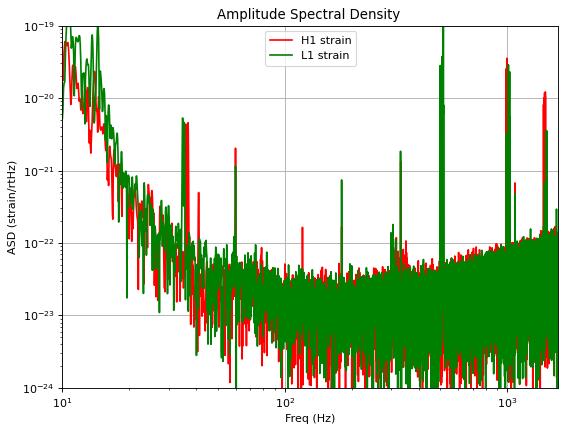

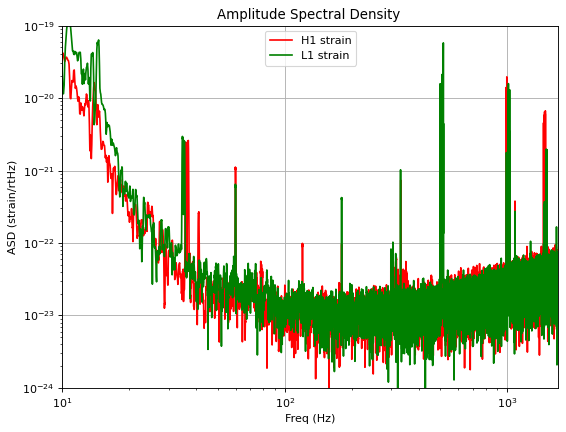

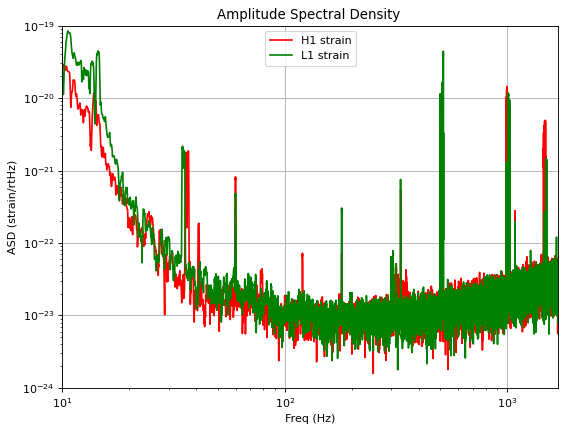

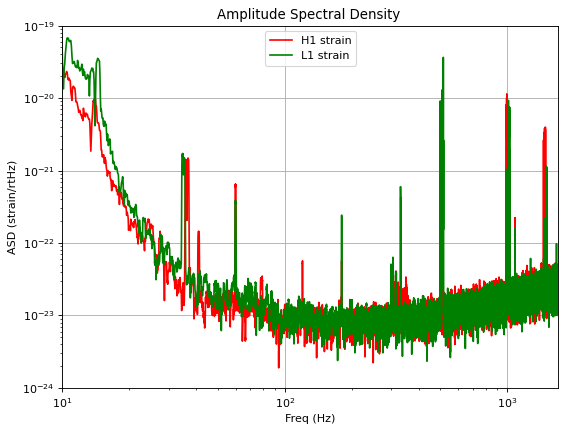

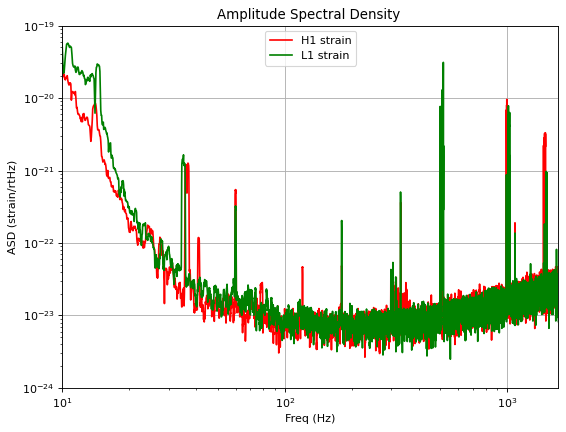

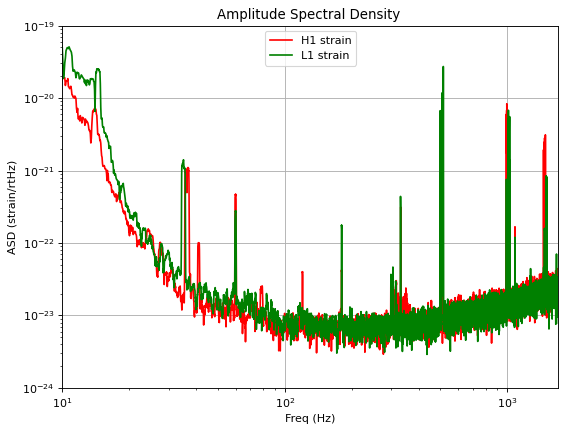

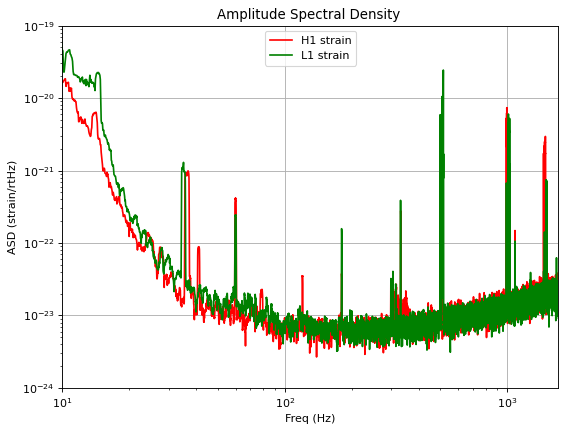

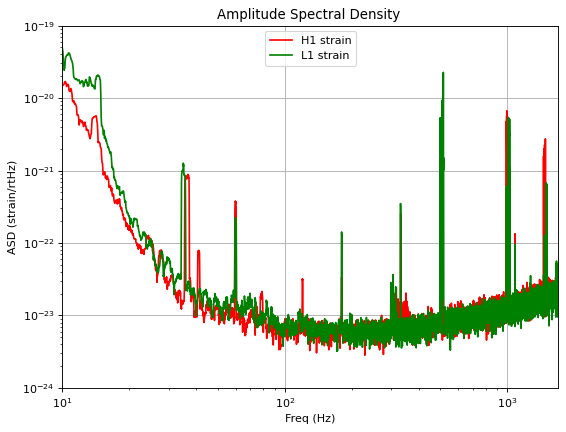

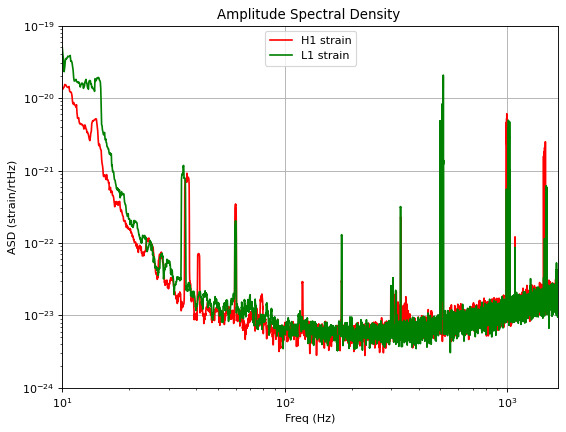

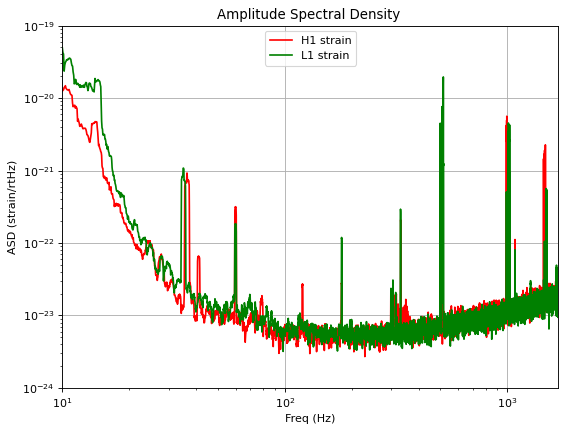

In [26]:
fmin = 10
fmax = 1700
for j in range(10):
    PxxH1_MT =  multitaperDPSS(dataH1[0:N_event],n=1+j,fs=4096)
    PxxL1_MT =  multitaperDPSS(dataL1[0:N_event],n=1+j,fs=4096)
    freqs1 = np.fft.fftfreq(len(dataH1[0:N_event]),d=1/4096)
    freqs2 = np.fft.fftfreq(len(dataL1[0:N_event]),d=1/4096)
    freqs1 = freqs1[:len(freqs1)//2]
    freqs2 = freqs2[:len(freqs2)//2]
    plotStrainASD(freqs1, freqs2, PxxH1_MT[:-1], PxxL1_MT[:-1], fmin, fmax, filename='ASD-Multitaper-Method-'+str(1+j)+'-taps.png')

Iteramos el valor de taps en el metodo multitaper y encontramos que se obtiene una estimacion razonable a los 10 taps.

In [27]:
PxxH1_MT =  multitaperDPSS(dataH1[0:N_event],n=10,fs=4096)
PxxL1_MT =  multitaperDPSS(dataL1[0:N_event],n=10,fs=4096)

31001
31001


# Metodo de Blackman-Tukey

Para estimar el espectro del ruido se decidio tomar muestras de la senal de forma tal que no se inlcluya el periodo de tiempo en el que aparece la señal correspondiente a la onda gravitacional.
El evento empieza en el segundo 15.42 del archivo utilizado.Dado que la frecuencia de muestreo del archivo es de 4096Hz, el tiempo del evento corresponderia a la muestra numero:
 $$N_{ev} = 15.42seg . 4096Hz= 63160.32 = 63160  $$

Por lo que para no incluir al evento se eligen tomar muestras por debajo de 67264, para tener un margen de seguridad se eligio utilizar aproximadamente 1000 muestras por debajo de dicho limite:
$$N=62000$$
N es el valor de muestras utilizadas de la senal para estimar la autocorrelacion de la señal.
Mientras que para el valor de la cantidad de valores que se desea calcular de la autocorrrelacion (denominado L). Se decidio tomar:
$$L= N$$
Este valor se eligio ya que el tiempo de calculo no es ningun limitante en este caso y se desea la mayor resolucion epectral posible. 

In [29]:
def BlackmanTukey(data,N,L,M,nperseg=None):
  if nperseg==None:
    nperseg = 2*L-1
  #Estimate autocorrelation
  rx = np.correlate(data[0:N],data[0:N],mode='full') / N
  rx_truncated = rx[(N-L):(N+L-1)]
  #Apply window
  x = ( (2*M+1)/L )*np.linspace(start=-L,stop=L,endpoint=False,num=2*L-1,dtype=int)
  window = ( (2*M+1)/L )*np.sinc(x)
  windowed_rx = rx_truncated*window
  #Calculate spectrum
  return abs( np.fft.rfft(windowed_rx,n=nperseg) )

In [30]:
N = 62000
L = N
M = 32

Estimo la correlacion de la señal

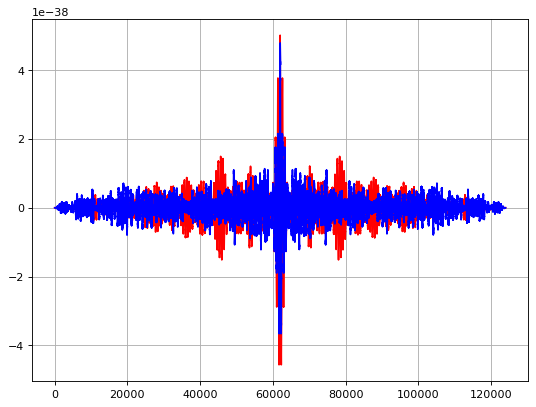

In [31]:
#Calculo rx para H1
meanless_h1 = dataH1[0:N] - np.mean(dataH1[0:N])
rx_h1 = np.correlate(meanless_h1,meanless_h1,mode='full') / N
rx_truncated_h1 = rx_h1[(N-L):(N+L-1)]
#Calculo rx para L1
meanless_l1 = dataL1[0:N] - np.mean(dataL1[0:N])
rx_l1 = np.correlate(meanless_l1,meanless_l1,mode='full') / N
rx_truncated_l1 = rx_l1[(N-L):(N+L-1)]

plt.figure(num=None, figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')
plt.grid('on')
plt.plot(rx_truncated_h1,'r')
plt.plot(rx_truncated_l1,'b')
plt.show()

Aplico la ventana

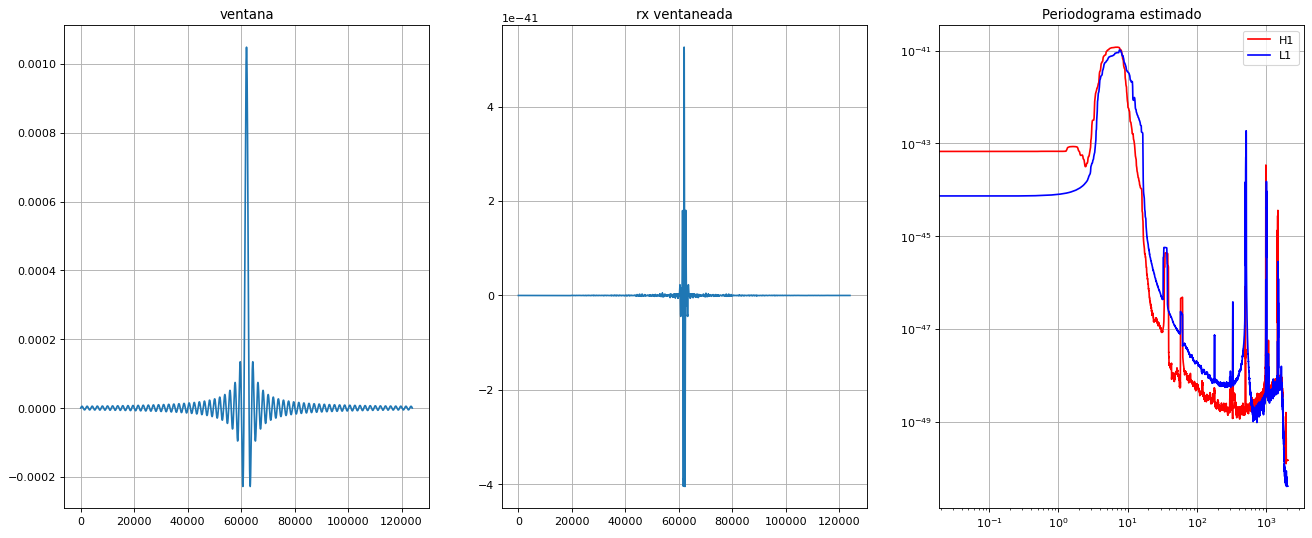

In [32]:
x = ( (2*M+1)/L )*np.linspace(start=-L,stop=L,endpoint=False,num=2*L-1,dtype=int)
window = ( (2*M+1)/L )*np.sinc(x)

windowed_rx_h1 = rx_truncated_h1*window
spectrum_h1 = norm*abs( np.fft.rfft(windowed_rx_h1) )

windowed_rx_l1 = rx_truncated_l1*window
spectrum_l1 = norm*abs( np.fft.rfft(windowed_rx_l1) )

f = np.fft.fftfreq(n=len(windowed_rx_h1),d=1./4096)
#fig = plt.figure(figsize=(20,8))
plt.figure(num=None, figsize=(20,8), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(131)
plt.grid('on')
plt.plot(window)
plt.title("ventana")
plt.subplot(132)
plt.grid('on')
plt.plot(windowed_rx_h1)
plt.title("rx ventaneada")
plt.subplot(133)
plt.title("Periodograma estimado")
plt.plot(f[0:L],spectrum_h1,'r',label='H1')
plt.plot(f[0:L],spectrum_l1,'b',label='L1')
plt.legend(loc="upper right")
plt.yscale("log")
plt.xscale("log")
plt.grid(True)
plt.show()

In [33]:
def AddSpectrumPlot(f_vect,spectrum,title,index,row=2,column=3):
  plt.subplot(row,column,index)
  plt.title(title)
  plt.plot(f_vect,spectrum)
  plt.yscale("log")
  plt.grid(True)

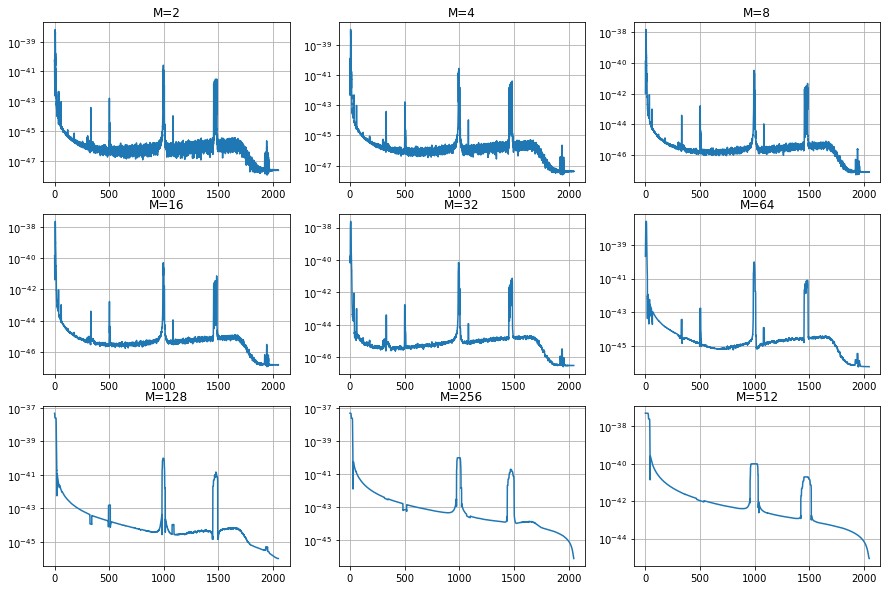

In [34]:
M_values = [2,4,8,16,32,64,128,256,512]
fig = plt.figure(figsize=(15,10))

for i in range(0,len(M_values)):
  M_test = M_values[i]
  x = ( (2*M_test+1)/L )*np.linspace(start=-L,stop=L,endpoint=False,num=2*L-1,dtype=int)
  window = ( (2*M_test+1)/L )*np.sinc(x)
  windowed_rx = rx_truncated_h1*window
  Rx_ps = np.fft.fft(windowed_rx)
  f = np.fft.fftfreq(n=len(windowed_rx),d=1./4096)
  AddSpectrumPlot(f[0:L],abs(Rx_ps)[0:L],title="M="+str(M_test),index=i+1,row=3,column=3)


plt.show()

Como ultima variable a definir, se decidio utilizar para el filtro moving average:
$$M=32$$
Se puede apreciar en las graficas anteriores que dicho valor parece estar justo en el limite entre un mejor suavizado y una perdida de detalle debido a falta de resolucion en frecuencia. La resolucion en frecuencia del espectro es obtiene como:
$$\triangle f=\frac{2M+1}{N}f_s=\frac{2*32+1}{62000}4096Hz\approx4Hz$$
Con este valor de M se obtiene una resolucion de 4Hz, ya con el proximo vaalor de M=64 la resolucion empeora a 8Hz.

# Comparacion entre estimaciones

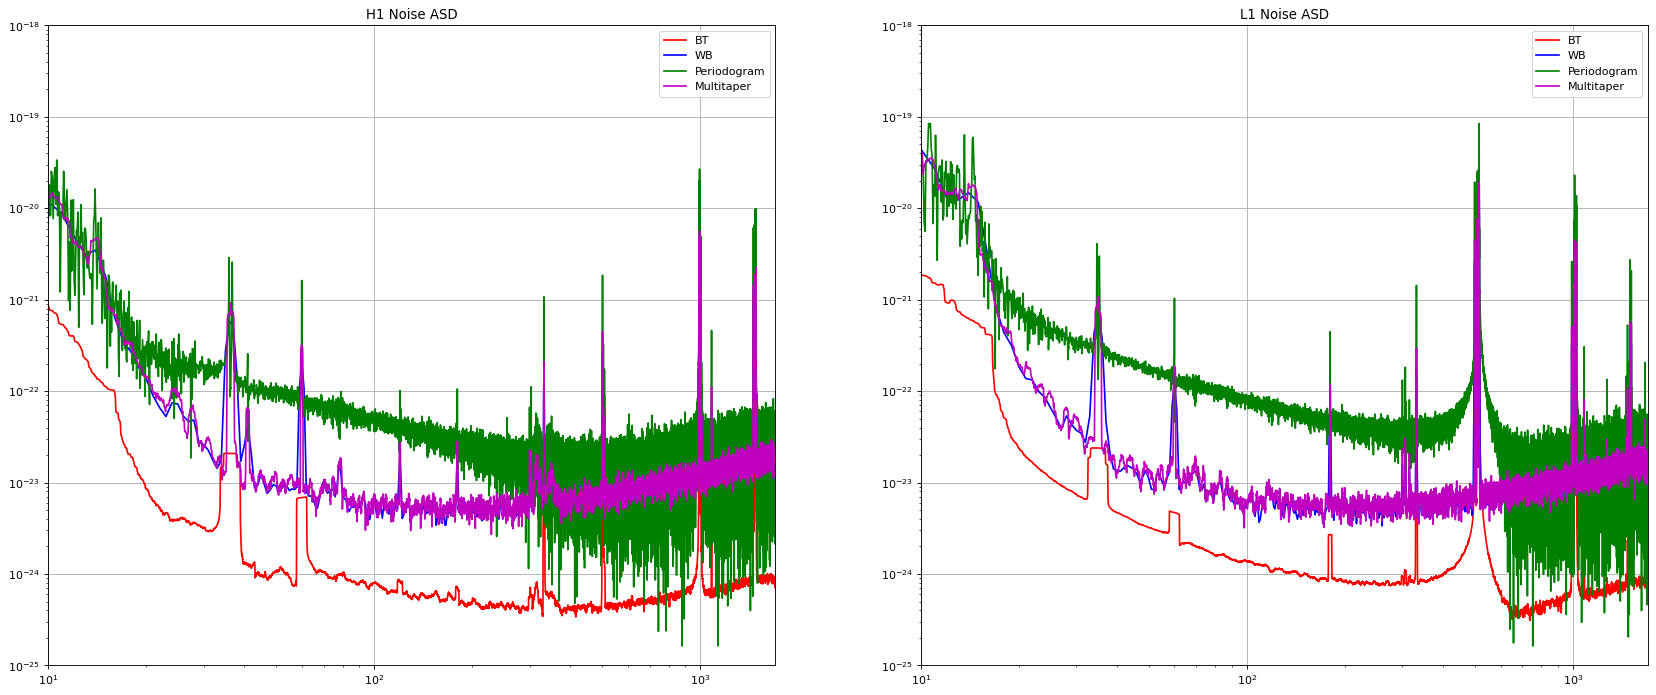

In [35]:
plt.figure(num=None, figsize=(20,8), dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.2, wspace = 0.2)
fmin = 10
fmax = 1700
yMin = 1e-25
yMax = 1e-18
#H1
f1 = np.fft.rfftfreq(2*len(spectrum_h1)-1,d=1./4096.) #BT freqs
f2 = np.fft.rfftfreq(2*len(PxxH1_WB)-1,d=1./4096.)    #WB freqs
f3 = np.fft.rfftfreq(2*len(fftH1)-1,d=1./4096.)    #WB freqs
f4 = np.fft.fftfreq(len(dataH1[0:N_event]),d=1/4096)
f4 = f4[:len(f4)//2]
plt.subplot(121)
plt.title("H1 Noise ASD")
plt.plot(f1,np.sqrt(spectrum_h1),'r',label='BT')
plt.plot(f2,np.sqrt(PxxH1_WB),'b',label='WB')
plt.plot(f3,np.sqrt(PxxH1_FFT),'g',label='Periodogram')
plt.plot(f4,np.sqrt(PxxH1_MT[:-1]),'m',label='Multitaper')

plt.legend(loc="upper right")
plt.yscale("log")
plt.xscale("log")
plt.axis([fmin, fmax, yMin, yMax])
plt.grid(True)

#L1
f1 = np.fft.rfftfreq(2*len(spectrum_l1)-1,d=1./4096.) #BT freqs
f2 = np.fft.rfftfreq(2*len(PxxL1_WB)-1,d=1./4096.)    #WB freqs
f3 = np.fft.rfftfreq(2*len(fftL1)-1,d=1./4096.)    #WB freqs
f4 = np.fft.fftfreq(len(dataL1[0:N_event]),d=1/4096)
f4 = f4[:len(f4)//2]
plt.subplot(122)
plt.title("L1 Noise ASD")
plt.plot(f1,np.sqrt(spectrum_l1),'r',label='BT')
plt.plot(f2,np.sqrt(PxxL1_WB),'b',label='WB')
plt.plot(f3,np.sqrt(PxxL1_FFT),'g',label='Periodogram')
plt.plot(f4,np.sqrt(PxxL1_MT[:-1]),'m',label='Multitaper')

plt.legend(loc="upper right")
plt.yscale("log")
plt.xscale("log")
plt.axis([fmin, fmax, yMin, yMax])
plt.grid(True)

plt.show()


Se puede apreciar en los graficos que en ambos casos el metodo con mejor resolucion y menor varianza pareceria ser el de Welch Bartlett seguido por Multitaper. El peor resulta ser el periodograma, el cual tiene la mayor varianza y bias. Por otro lado, Blackman tukey es el que tien el menor bias y la menor varianza, pero la peor resolucion en frecuencia de todos los metodos. En conclusion, para los calculos futuros decidimos utilizar el metodo Welch Bartlett con:
$$ D=0 $$
$$ L=2^{10} $$
$$ Ventana=Hann $$

# Estimacion de la funcion de distribucion de probabilidad

## H1

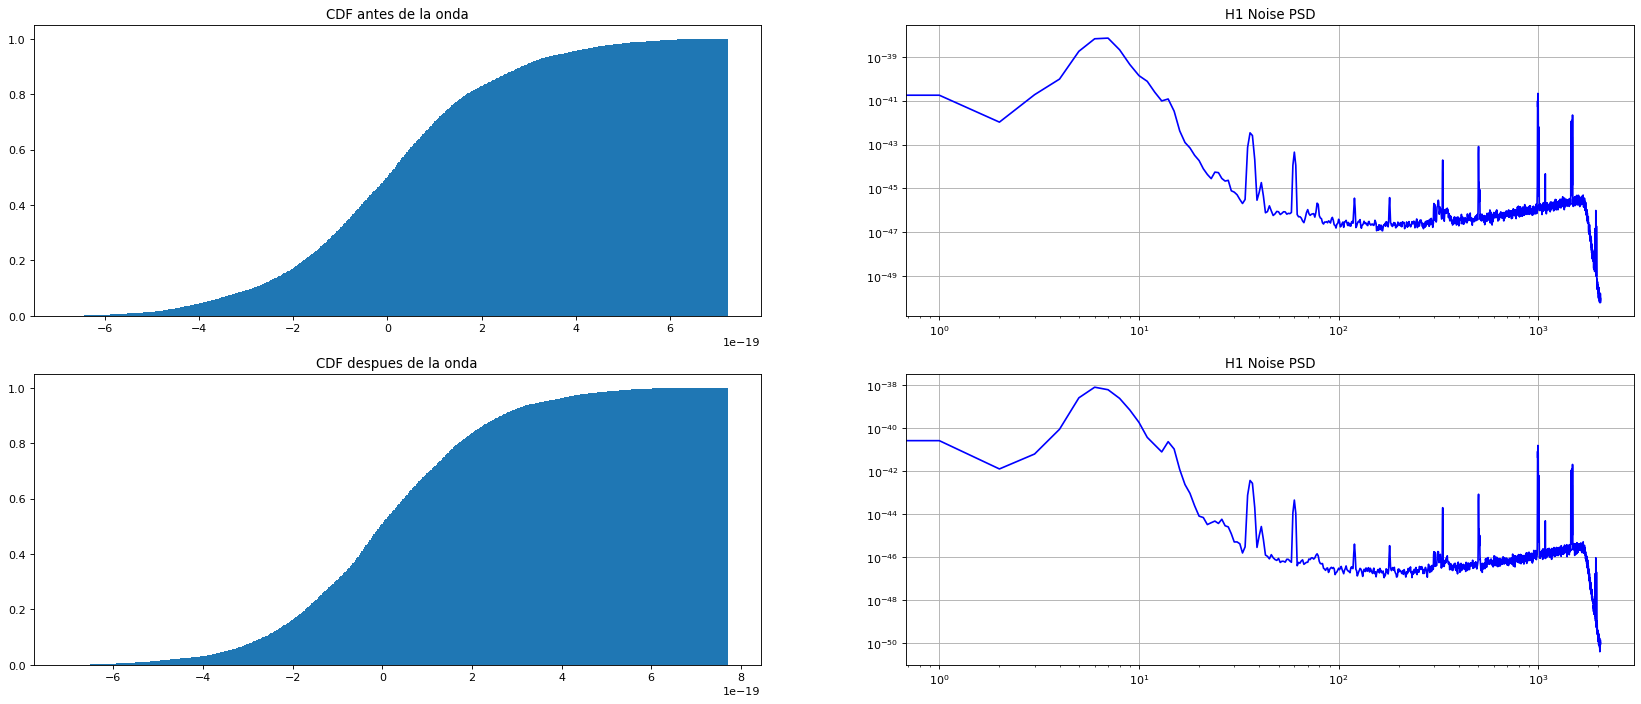

In [36]:
T_start = 63160
T_end = 63160+1024

plt.figure(num=None, figsize=(20,8), dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.2, wspace = 0.2)

plt.subplot(221)
plt.title("CDF antes de la onda")
plt.hist(dataH1[0:T_start], bins=500,cumulative=True,density=True)

plt.subplot(222)
plt.title("H1 Noise PSD")
f = np.fft.rfftfreq(2*len(PxxH1_WB)-1,d=1./4096.)    #WB freqs
plt.plot(f,PxxH1_WB,'b')
plt.yscale("log")
plt.xscale("log")
plt.grid(True)

plt.subplot(223)
plt.title("CDF despues de la onda")
plt.hist(dataH1[T_end:], bins=500,cumulative=True,density=True)

plt.subplot(224)
plt.title("H1 Noise PSD")
PxxH1_WB_end = welchBartlett(dataH1[T_end:], fs=4096, D=0, L=nperseg, k=len(dataH1[T_end:])//nperseg, window = signal.get_window('hann', nperseg))
f = np.fft.rfftfreq(2*len(PxxH1_WB_end)-1,d=1./4096.)    #WB freqs
plt.plot(f,PxxH1_WB_end,'b')
plt.yscale("log")
plt.xscale("log")
plt.grid(True)
plt.show()

A simple viste pareceria que no hay ninguna diferencia notable entre la funcion distribucion de probabilidad del ruido antes de la onda y despues.
Lo mismo se puede decir del espectro de potencia del ruido, por lo que se concluye que el ruido se puede tratar como estacionario en los 32 segundos de la señal.

## L1

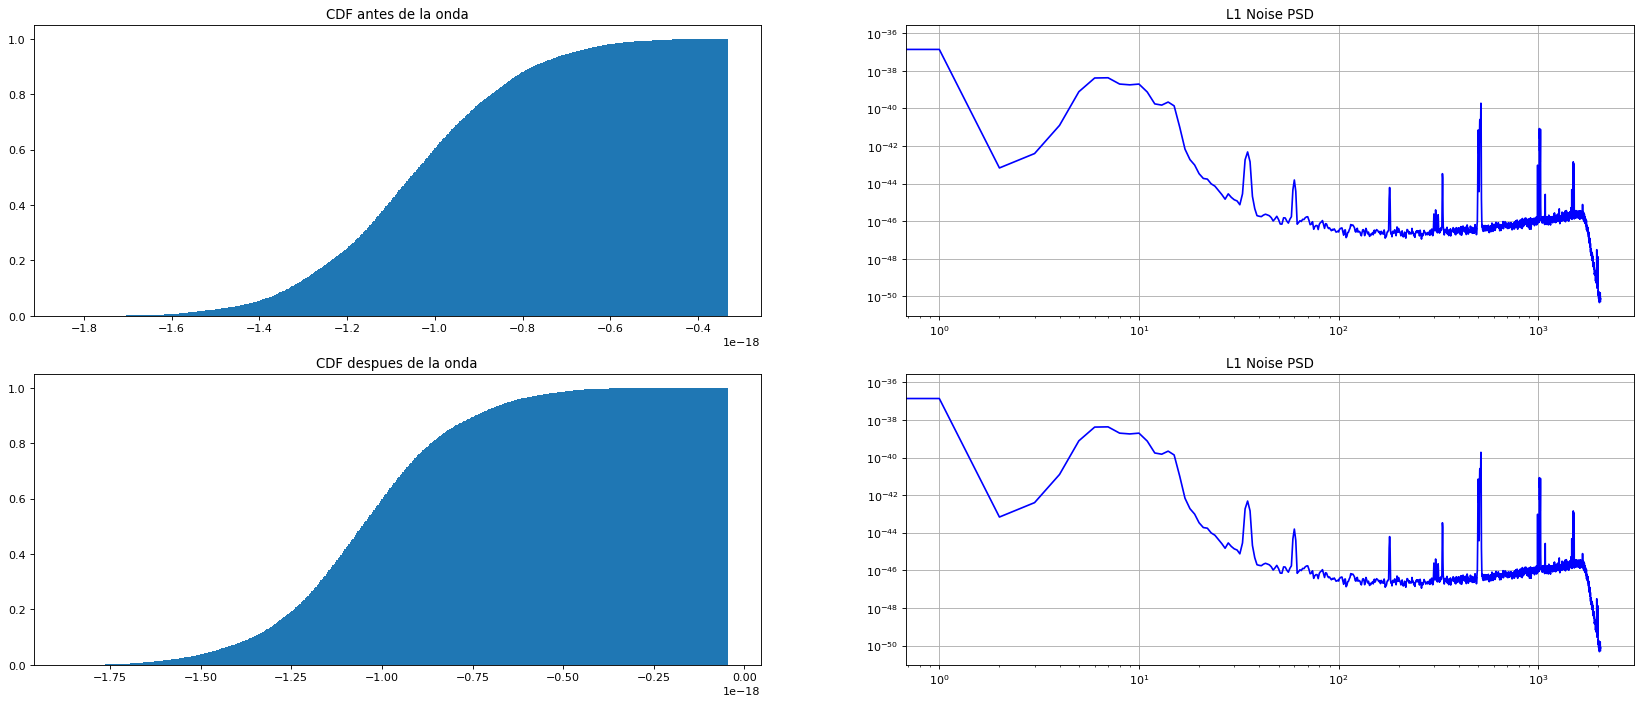

In [37]:
T_start = 63160
T_end = 63160+1024


plt.figure(num=None, figsize=(20,8), dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.2, wspace = 0.2)

plt.subplot(221)
plt.title("CDF antes de la onda")
plt.hist(dataL1[0:T_start], bins=500,cumulative=True,density=True)

plt.subplot(222)
plt.title("L1 Noise PSD")
f = np.fft.rfftfreq(2*len(PxxL1_WB)-1,d=1./4096.)    #WB freqs
plt.plot(f,PxxL1_WB,'b')
plt.yscale("log")
plt.xscale("log")
plt.grid(True)

plt.subplot(223)
plt.title("CDF despues de la onda")
plt.hist(dataL1[T_end:], bins=500,cumulative=True,density=True)

plt.subplot(224)
plt.title("L1 Noise PSD")
PxxL1_WB_end = welchBartlett(dataL1[T_end:], fs=4096, D=0, L=nperseg, k=len(dataL1[T_end:])//nperseg, window = signal.get_window('hann', nperseg))
f = np.fft.rfftfreq(2*len(PxxL1_WB_end)-1,d=1./4096.)    #WB freqs
plt.plot(f,PxxL1_WB,'b')
plt.yscale("log")
plt.xscale("log")
plt.grid(True)
plt.show()

Comparando las graficas de la primera y la segunda mitad del set de datos podemos apreciar que no se perciben diferencias notables entre ambas.
Por lo que al igual que para H1, se cumple que el ruido se comporta como estacionario en los 32 segundos del dataset.

# Whitening

In [94]:
from matplotlib import colors
# function to whiten data
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs) /dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

def AddSpectrogramPlot(nfft,nperseg,data,title,index,row=2,column=2,fs=4096):
    norm = fs/2
    plt.subplot(row,column,index)
    plt.title(title)
    f,t,Pxx = signal.spectrogram(data, fs=fs, nperseg=nperseg, nfft=nfft, scaling='spectrum',window='blackman')
    plt.pcolormesh(t, f, Pxx, cmap="viridis", shading='auto',norm=colors.LogNorm(vmin=np.amin(Pxx), vmax=np.amax(Pxx)))
    plt.ylim(top=2000)

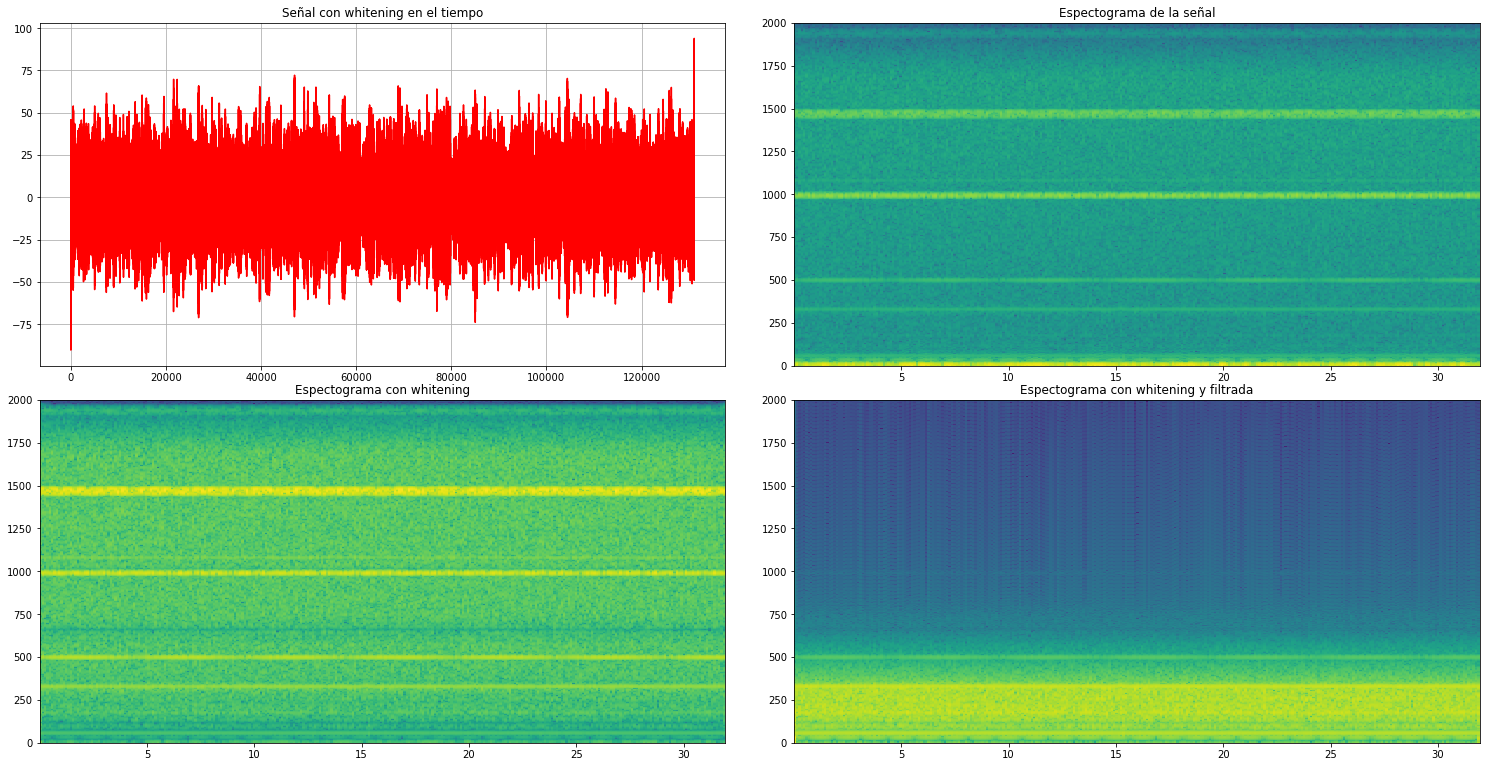

In [98]:
nperseg = 2**10
psd_noise_h1 = welchBartlett(dataH1[0:62000], fs=4096, D=0, L=nperseg, k=62000//nperseg, window = signal.get_window('hann', nperseg), padding=len(dataH1)-nperseg)
psd_noise_l1 = welchBartlett(dataL1[0:62000], fs=4096, D=0, L=nperseg, k=62000//nperseg, window = signal.get_window('hann', nperseg), padding=len(dataH1)-nperseg)
psd_func_h1 = interp1d(np.fft.fftfreq(len(psd_noise_h1),d=1./fs),psd_noise_h1, fill_value="extrapolate")
psd_func_l1 = interp1d(np.fft.fftfreq(len(psd_noise_l1),d=1./fs),psd_noise_l1, fill_value="extrapolate")
whitened_signal_h1 = whiten(dataH1,psd_func_h1,1./fs)
whitened_signal_l1 = whiten(dataL1,psd_func_l1,1./fs)

plt.figure(figsize=(20,10))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.1, wspace = 0.1)
plt.subplot(221)
plt.title("Señal con whitening en el tiempo")
plt.plot(whitened_signal_h1,'r',label='H1')
plt.grid(True)
#original
AddSpectrogramPlot(nfft=8192,nperseg=512,data=dataH1,title="Espectograma de la señal",index=2)
#Whitening
AddSpectrogramPlot(nfft=8192,nperseg=512,data=whitened_signal_h1,title="Espectograma con whitening",index=3)

#Whitening y filtrada
bb, ab = signal.butter(6, [30.*2./fs, 300.*2./fs], btype='band')
filtered_signal_h1 = signal.filtfilt(bb, ab, whitened_signal_h1)
filtered_signal_l1 = signal.filtfilt(bb, ab, whitened_signal_l1)
AddSpectrogramPlot(nfft=8192,nperseg=512,data=filtered_signal_h1,title="Espectograma con whitening y filtrada",index=4)
plt.savefig('whitening.png')
plt.show()


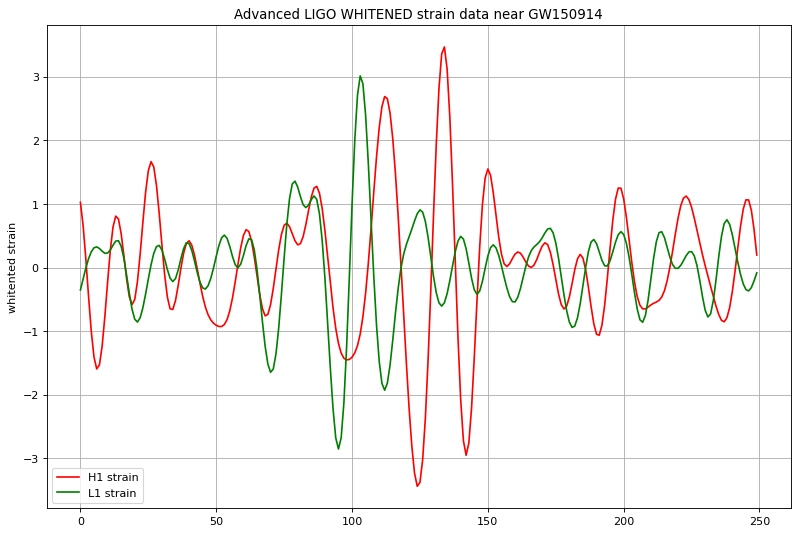

In [55]:
Nevent = 63160-100
Nend = 63160+150
# plot the data after whitening:
plt.figure(num=None, figsize=(12,8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(filtered_signal_h1[Nevent:Nend],'r',label='H1 strain')
plt.plot(strain_L1_shift[Nevent:Nend],'g',label='L1 strain')
plt.ylabel('whitented strain')
plt.legend(loc='lower left')
plt.grid('on')
plt.title('Advanced LIGO WHITENED strain data near GW150914')
plt.savefig('GW150914_strain_whitened.png')

In [41]:
IPython.display.Audio(filtered_signal_h1[Nevent-2000:Nend+2000]**7,rate=4096)

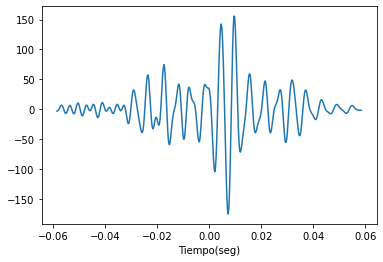

Tomando el primer pico se ve que el delay entre mediciones es de: 7.339ms


In [61]:
cross_corr1 = signal.correlate(filtered_signal_h1[Nevent:Nend],filtered_signal_l1[Nevent:Nend])
t = np.linspace(start=-len(cross_corr1)/4096/2,stop=len(cross_corr1)/4096/2,num=len(cross_corr1))
offset = 10
plt.plot(t[offset:-offset],cross_corr1[offset:-offset])
plt.xlabel("Tiempo(seg)")
plt.show()
max_element_pos1 = np.argmax(abs(cross_corr1[offset:-offset]))
delay_in_ms = np.round(1000*t[offset+max_element_pos1],decimals=3)
print("Tomando el primer pico se ve que el delay entre mediciones es de: "+str(delay_in_ms)+"ms")

# Pavel Naselsky, Andrew D. Jackson and Hao Liu Paper Implementation

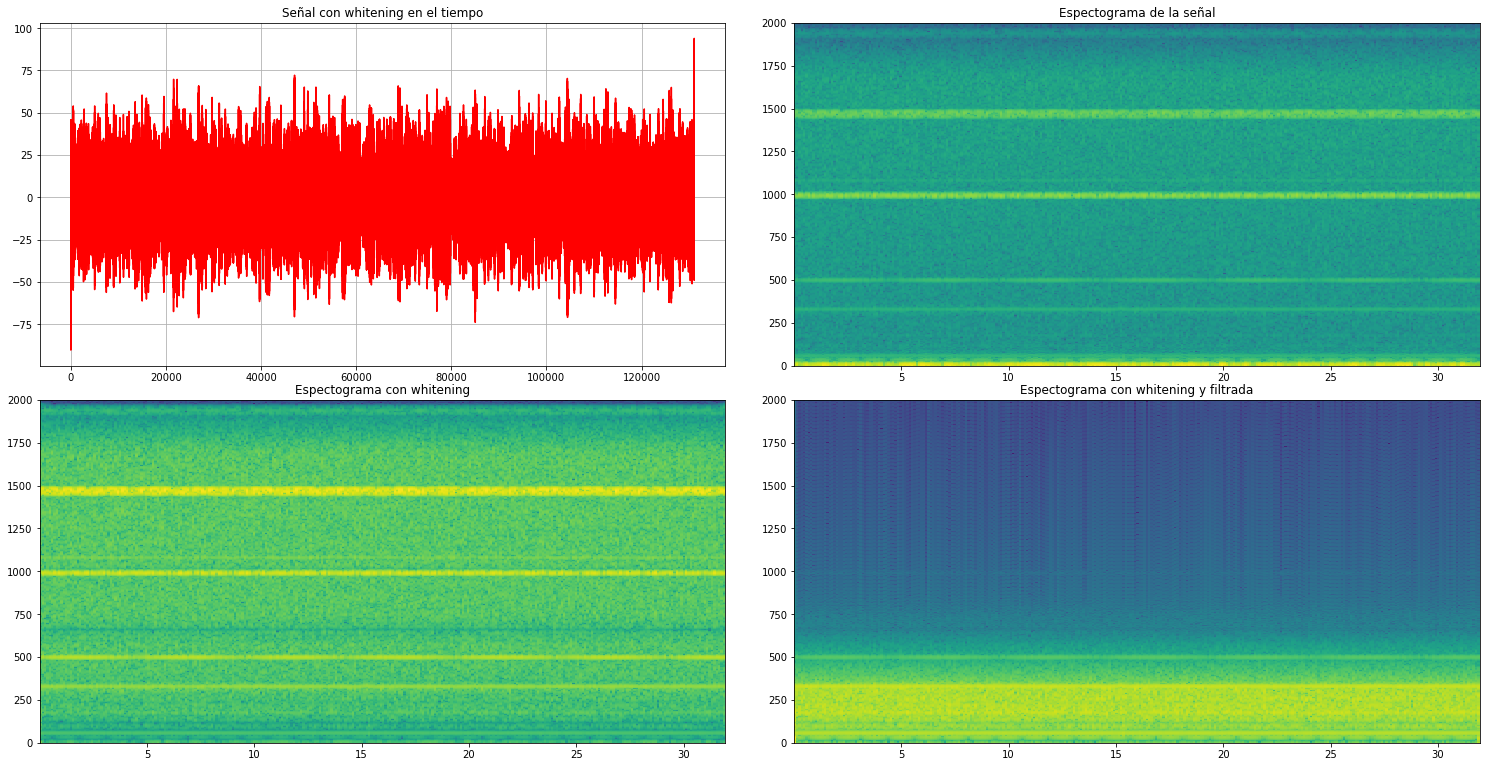

In [99]:
nperseg = 2**10
psd_noise_h1 = welchBartlett(dataH1[0:62000], fs=4096, D=0, L=nperseg, k=62000//nperseg, window = signal.get_window('hann', nperseg), padding=len(dataH1)-nperseg)
psd_noise_l1 = welchBartlett(dataL1[0:62000], fs=4096, D=0, L=nperseg, k=62000//nperseg, window = signal.get_window('hann', nperseg), padding=len(dataH1)-nperseg)
psd_func_h1 = interp1d(np.fft.fftfreq(len(psd_noise_h1),d=1./fs),psd_noise_h1, fill_value="extrapolate")
psd_func_l1 = interp1d(np.fft.fftfreq(len(psd_noise_l1),d=1./fs),psd_noise_l1, fill_value="extrapolate")
whitened_signal_h1 = whiten(dataH1,psd_func_h1,1./fs)
whitened_signal_l1 = whiten(dataL1,psd_func_l1,1./fs)

plt.figure(figsize=(20,10))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.1, wspace = 0.1)
plt.subplot(221)
plt.title("Señal con whitening en el tiempo")
plt.plot(whitened_signal_h1,'r',label='H1')
plt.grid(True)
#original
AddSpectrogramPlot(nfft=8192,nperseg=512,data=dataH1,title="Espectograma de la señal",index=2)
#Whitening
AddSpectrogramPlot(nfft=8192,nperseg=512,data=whitened_signal_h1,title="Espectograma con whitening",index=3)

#Whitening y filtrada
bb, ab = signal.butter(6, [30.*2./fs, 300.*2./fs], btype='band')
filtered_signal_h1 = signal.filtfilt(bb, ab, whitened_signal_h1)
filtered_signal_l1 = signal.filtfilt(bb, ab, whitened_signal_l1)
# Filtrar con Notch!!
AddSpectrogramPlot(nfft=8192,nperseg=512,data=filtered_signal_h1,title="Espectograma con whitening y filtrada",index=4)
plt.savefig('whitening.png')
plt.show()

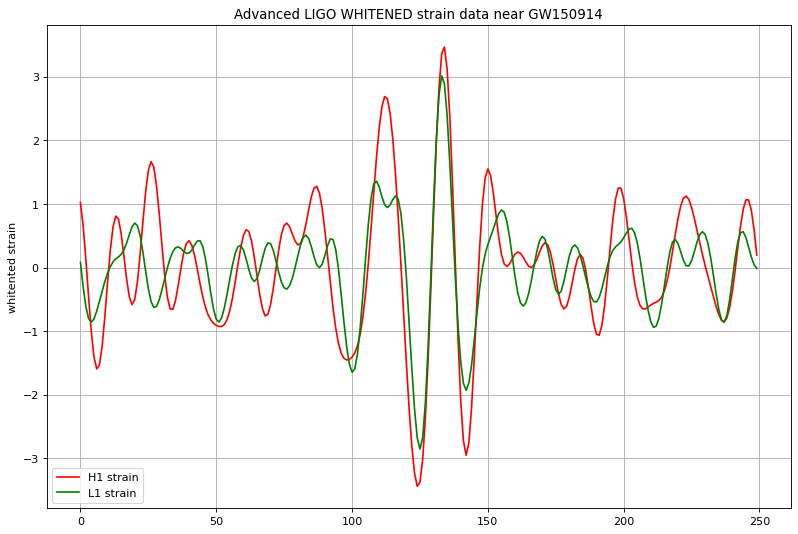

In [100]:
Nevent = 63160-100
Nend = 63160+150
# plot the data after whitening:
strain_L1_shift = -np.roll(filtered_signal_l1,int(0.00734*fs))
plt.figure(num=None, figsize=(12,8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(filtered_signal_h1[Nevent:Nend],'r',label='H1 strain')
plt.plot(strain_L1_shift[Nevent:Nend],'g',label='L1 strain')
plt.ylabel('whitented strain')
plt.legend(loc='lower left')
plt.grid('on')
plt.title('Advanced LIGO WHITENED strain data near GW150914')
plt.savefig('GW150914_strain_whitened.png')

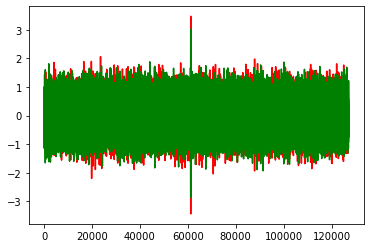

NameError: name 'seg_data_L1' is not defined

In [43]:
# We start by using the whitened signal before filtered_signal_h1 and strain_L1_shift
cutoff = 2000#2000
seg_samples = int(200*(10**-3)*4096)
final_H1 = filtered_signal_h1[cutoff:-cutoff]
final_L1 = strain_L1_shift[cutoff:-cutoff]
plt.plot(final_H1,'r',label='H1 strain')
plt.plot(final_L1,'g',label='L1 strain')
plt.show()
# We divide the records into shorter patches of length 200 ms.
segs_data_L1 = segmentation(final_L1,D=0,L=seg_samples,K=len(final_L1)//seg_samples)
segs_data_H1 = segmentation(final_H1,D=0,L=seg_samples,K=len(final_H1)//seg_samples)
# For each pair of H-L patches we calculate the Pearson cross-correlation coefficient C(t)
coefs = np.zeros(len(seg_data_L1))
for i in range(len(seg_data_L1)):
    seg_L1 = segs_data_L1[i]-np.mean(segs_data_L1[i])
    seg_H1 = segs_data_H1[i]-np.mean(segs_data_H1[i])
    num = np.sum(np.multiply(seg_L1, seg_H1))
    den = np.sqrt(np.sum(seg_L1**2)*np.sum(seg_H1**2))
    c = num/den
    coefs[i] = c
plt.plot(coefs)
plt.show()
max_val = np.amax(coefs)
print('Max value: ', max_val)
batch = np.where(coefs == max_val)[0][0]
print('Batch Number: ', batch)
plt.plot(final_H1[800*batch:800*(batch+1)],'r',label='H1 strain')
plt.plot(final_L1[800*batch:800*(batch+1)],'g',label='L1 strain')
Nevent = 63160-400-2000
Nend = 63160+400-2000
plt.show()
plt.plot(final_L1[Nevent:Nend],'g',label='L1 strain')
plt.plot(final_H1[Nevent:Nend],'g',label='H1 strain')
plt.show()
